In [1]:
using Revise # lets you change A2funcs without restarting julia!
includet("A2_src.jl")
using Plots
using Statistics: mean
using Zygote 
using Test
using Logging
using .A2funcs: log1pexp # log(1 + exp(x)) stable 
using .A2funcs: factorized_gaussian_log_density 
using .A2funcs: skillcontour!
using .A2funcs: plot_line_equal_skill!

In [2]:
function log_prior(zs)
    return  factorized_gaussian_log_density(0, 0, zs)
end

log_prior (generic function with 1 method)

In [3]:
function logp_a_beats_b(za,zb)
    return -log1pexp(zb-za)
end

logp_a_beats_b (generic function with 1 method)

In [4]:
function all_games_log_likelihood(zs,games)
    zs_a = zs[games[:,1],:]
    zs_b =  zs[games[:,2],:]
    likelihoods =  logp_a_beats_b.(zs_a, zs_b)
    return  sum(likelihoods, dims=1)
end

all_games_log_likelihood (generic function with 1 method)

In [5]:
function joint_log_density(zs,games)
    return log_prior(zs) + all_games_log_likelihood(zs, games)
end

joint_log_density (generic function with 1 method)

In [6]:
@testset "Test shapes of batches for likelihoods" begin
    B = 15 # number of elements in batch
    N = 4 # Total Number of Players
    test_zs = randn(4,15)
    test_games = [1 2; 3 1; 4 2] # 1 beat 2, 3 beat 1, 4 beat 2
    @test size(test_zs) == (N,B)
    #batch of priors
    @test size(log_prior(test_zs)) == (1,B)
    # loglikelihood of p1 beat p2 for first sample in batch
    @test size(logp_a_beats_b(test_zs[1,1],test_zs[2,1])) == ()
    # loglikelihood of p1 beat p2 broadcasted over whole batch
    @test size(logp_a_beats_b.(test_zs[1,:],test_zs[2,:])) == (B,)
    # batch loglikelihood for evidence
    @test size(all_games_log_likelihood(test_zs,test_games)) == (1,B)
    # batch loglikelihood under joint of evidence and prior
    @test size(joint_log_density(test_zs,test_games)) == (1,B)
end

Test Summary:                          | Pass  Total
Test shapes of batches for likelihoods |    6      6


Test.DefaultTestSet("Test shapes of batches for likelihoods", Any[], 6, false)

In [7]:
# Convenience function for producing toy games between two players.
two_player_toy_games(p1_wins, p2_wins) = vcat([repeat([1,2]',p1_wins), repeat([2,1]',p2_wins)]...)

# Example for how to use contour plotting code
plot(title="Example Gaussian Contour Plot",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill"
   )

# TODO: plot prior contours
example_gaussian(zs) = exp(factorized_gaussian_log_density([-1.,2.],[0.,0.5],zs))
skillcontour!(example_gaussian)
plot_line_equal_skill!()
savefig(joinpath("plots","prior_contours"))

In [8]:
# TODO: plot likelihood contours
plot(title="Likelihood Contour Plot",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill")
likelihood(zs) = exp.(logp_a_beats_b.(zs[1,:], zs[2,:]))
skillcontour!(likelihood)
plot_line_equal_skill!()
savefig(joinpath("plots", "likelihood_contours"))

In [9]:
# TODO: plot joint contours with player A winning 1 game
plot(title="Joint Contour Plot 1 Game",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill")
one_game = two_player_toy_games(1, 0)
joint_posterior_1(zs) = exp(joint_log_density(zs, one_game))
skillcontour!(joint_posterior_1)
plot_line_equal_skill!()
savefig(joinpath("plots", "posterior_contours_1"))

In [10]:
# TODO: plot joint contours with player A winning 10 games
plot(title="Joint Contour Plot 10 Games (d)",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill")
ten_games = two_player_toy_games(10, 0)
joint_posterior_10d(zs) = exp(joint_log_density(zs, ten_games))
skillcontour!(joint_posterior_10d)
plot_line_equal_skill!()
savefig(joinpath("plots", "posterior_contours_10d"))

In [11]:
#TODO: plot joint contours with player A winning 10 games and player B winning 10 games
plot(title="Joint Contour Plot 20 Games (e)",
    xlabel = "Player 1 Skill",
    ylabel = "Player 2 Skill")
twenty_games = two_player_toy_games(10, 10)
joint_posterior_20e(zs) = exp(joint_log_density(zs, twenty_games))
skillcontour!(joint_posterior_20e)
plot_line_equal_skill!()
savefig(joinpath("plots", "posterior_contours_20e"))

In [12]:
function elbo(params, logp, num_samples)
  mu, logsig = params
  samples = mu .+ exp.(logsig) .* randn(size(mu)[1], num_samples)
  logp_estimate = logp(samples)
  logq_estimate = factorized_gaussian_log_density(mu, logsig, samples)
  return mean(logp_estimate .- logq_estimate)#TODO: should return scalar (hint: average over batch)
end

elbo (generic function with 1 method)

In [13]:
# Conveinence function for taking gradients 
function neg_toy_elbo(params; games = two_player_toy_games(1,0), num_samples = 100)
  # TODO: Write a function that takes parameters for q, 
  # evidence as an array of game outcomes,
  # and returns the -elbo estimate with num_samples many samples from q
  logp(zs) = joint_log_density(zs,games)
  return -elbo(params,logp, num_samples)
end

neg_toy_elbo (generic function with 1 method)

In [14]:
# Toy game
num_players_toy = 2 
toy_mu = [-2.,3.] # Initial mu, can initialize randomly!
toy_ls = [0.5,0.] # Initual log_sigma, can initialize randomly!
toy_params_init = (toy_mu, toy_ls)

([-2.0, 3.0], [0.5, 0.0])

In [15]:
function fit_toy_variational_dist(init_params, toy_evidence; num_itrs=200, lr= 1e-2, num_q_samples = 10, fp="TvsV")
  params_cur = init_params 
  for i in 1:num_itrs
    grad_params = gradient(params_cur -> neg_toy_elbo(params_cur; games=toy_evidence, num_samples=num_q_samples), params_cur)#TODO: gradients of variational objective with respect to parameters
    mu, logsig = params_cur
    mu -= lr .* grad_params[1][1]
    logsig -= lr .* grad_params[1][2]
    params_cur = mu, logsig  #TODO: update paramters with lr-sized step in descending gradient
    e = neg_toy_elbo(params_cur; games=toy_evidence, num_samples=num_q_samples)
    @info "ELBO:" e#TODO: report the current elbbo during training
    # TODO: plot true posterior in red and variational in blue
    # hint: call 'display' on final plot to make it display during training
    
    plot(title="Target Dist vs Variational Approx",
            xlabel="Player 1 Skill",
            ylabel="Player 2 Skill");
    
    if i == num_itrs - 1
        true_dist(zs) = exp(joint_log_density(zs, toy_evidence))
        variational_dist(zs) = exp(factorized_gaussian_log_density(mu, logsig, zs))
        skillcontour!(true_dist,colour=:red) # plot likelihood contours for target posterior
        plot_line_equal_skill!()
        display(skillcontour!(variational_dist, colour=:blue)) # plot likelihood contours for variational posterior
        #TODO: save final posterior plots
        savefig(joinpath("plots", fp))
    end
  end
  return params_cur
end

fit_toy_variational_dist (generic function with 1 method)

┌ Info: ELBO:
│   e = -9.883051159701361
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -11.69629375985414
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -8.36398760388424
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -10.723882103206181
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -9.578386572374342
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -12.024067654320543
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -12.567423102639825
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -13.143253917722152
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -7.263384367949049
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -10.63256535669686
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -8.733865216358502
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -8.93500400172165
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -7.154823468473834
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -6.959291622587547
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -9.109550482528565
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -12.777789239871003
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -6.284163450156

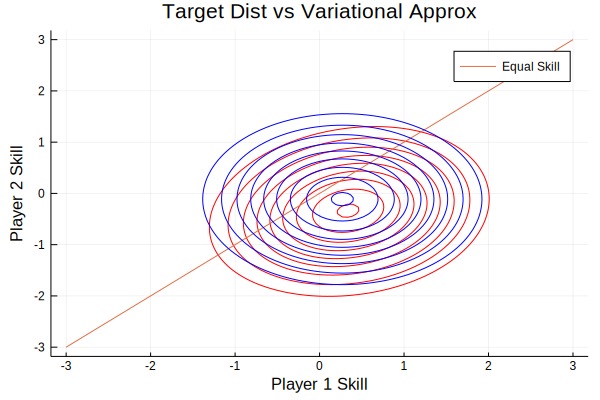

┌ Info: ELBO:
│   e = -1.7124172375667412
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.202008571060767
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -1.6906153189454485
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.464625510454251
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.4414967525647007
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.0389336220230727
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.6938394330538333
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -0.816403542644958
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -1.7436139519745057
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.1908852398488623
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -1.3408292856488735
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.1909147201837964
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.3409413687191996
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -1.320264935147374
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -1.7497404032906263
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.0069534039952868
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.356

([0.274288, -0.118404], [-0.0820881, -0.0784033])

In [16]:
#TODO: fit q with SVI observing player A winning 1 game
one_game = two_player_toy_games(1, 0)
fp = "Toy_vs_Var_1"
fitted = fit_toy_variational_dist(toy_params_init, one_game; fp=fp)

┌ Info: ELBO:
│   e = -56.019123872708974
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -47.95042315978042
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -43.39618517299364
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -54.08933653662721
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -38.358219098627885
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -38.82207770906093
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -30.171337599959525
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -42.00770042773807
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -31.281609827339246
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -34.729413583671885
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -37.649489166617926
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -37.38097009453186
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -24.5159227303114
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -19.572774718849143
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -21.426489502955143
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -27.482270995249287
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -14.641255

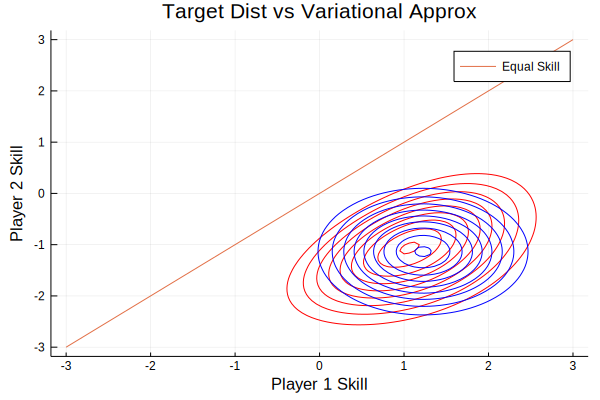

┌ Info: ELBO:
│   e = -2.8891985360008245
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.2202582266754454
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.1715392750974747
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.91323178741608
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.054104817634363
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.433594365401528
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.0577867836735226
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.9387870306080632
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.7179084238100897
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.8837551265170296
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.9888244259828562
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.8422487719738654
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.0762555348182405
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.8067276196404123
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.84555570835878
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -2.748398275685792
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -3.205419

([1.22984, -1.14149], [-0.368198, -0.373978])

In [17]:
#TODO: fit q with SVI observing player A winning 10 games
ten_games = two_player_toy_games(10, 0)
fp = "Toy_vs_Var_10"
fitted = fit_toy_variational_dist(toy_params_init, ten_games, fp=fp)
#TODO: save final posterior plots

┌ Info: ELBO:
│   e = -50.79789385858014
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -43.593398706622665
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -51.020662180353625
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -38.7152995289292
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -42.084609275601146
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -52.71718966963342
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -40.34161696662354
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -36.60994577114742
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -37.32256717062359
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -40.2680496494004
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -37.92316777248855
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -29.336239885533054
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -20.429571044258637
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -27.981171941036315
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -28.58024014933128
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -23.432914577928752
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -23.679109180

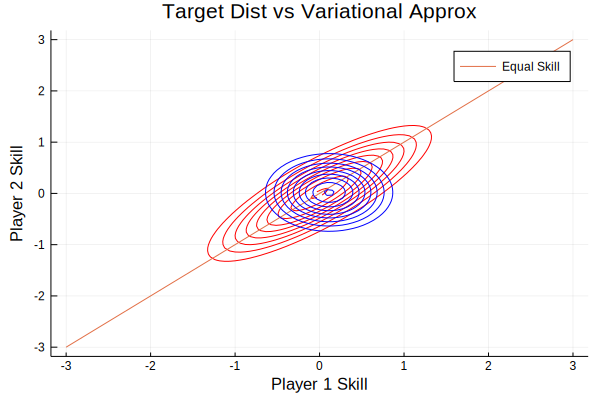

┌ Info: ELBO:
│   e = -15.077005976825788
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.356951979830402
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.561575111148334
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.892032356329015
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.236584332499067
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.271418929582447
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.806975780425162
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.501079652987224
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.812133638877146
└ @ Main In[15]:10
┌ Info: ELBO:
│   e = -15.77395333573198
└ @ Main In[15]:10


([0.101033, 0.0307741], [-0.86748, -0.859862])

In [18]:
#TODO: fit q with SVI observing player A winning 10 games and player B winning 10 games
twenty_games = two_player_toy_games(10, 10)
fp = "Toy_vs_Var_20"
fitted = fit_toy_variational_dist(toy_params_init, twenty_games, fp=fp)
#TODO: save final posterior plots

In [19]:
## Question 4
# Load the Data
using MAT
vars = matread("tennis_data.mat")
player_names = vars["W"]
tennis_games = Int.(vars["G"])
num_players = length(player_names)
print("Loaded data for $num_players players")

Loaded data for 107 players

In [20]:
function fit_variational_dist(init_params, tennis_games; num_itrs=200, lr= 1e-2, num_q_samples = 10)
  params_cur = init_params 
  for i in 1:num_itrs
    grad_params = gradient(params_cur -> neg_toy_elbo(params_cur; games=tennis_games, num_samples=num_q_samples), params_cur)#TODO: gradients of variational objective with respect to parameters
    mu, logsig = params_cur
    mu -= lr .* grad_params[1][1]
    logsig -= lr .* grad_params[1][2]
    params_cur = mu, logsig  #TODO: update paramters with lr-sized step in descending gradient
    e = neg_toy_elbo(params_cur; games=tennis_games, num_samples=num_q_samples)
    @info "ELBO:" e#TODO: report the current elbbo during training
  end
  return params_cur
end

fit_variational_dist (generic function with 1 method)

In [21]:
# TODO: Initialize variational family
init_mu = randn(num_players)#random initialziation
init_log_sigma = rand(num_players)# random initialziation
init_params = (init_mu, init_log_sigma)

([0.123935, 1.37156, 0.311126, 0.798796, -1.24083, 0.684507, 0.0524451, -1.90267, -1.35199, -0.0764493  …  -0.8945, 0.705152, -0.436082, -1.53979, 2.03165, -0.399097, 0.711378, 1.05927, -0.0900689, -0.262121], [0.299102, 0.397663, 0.539533, 0.859027, 0.852011, 0.808321, 0.945448, 0.24473, 0.274995, 0.412787  …  0.0264658, 0.519266, 0.436663, 0.723797, 0.419861, 0.835526, 0.658818, 0.463359, 0.2541, 0.631243])

In [22]:
# Train variational distribution
trained_params = fit_variational_dist(init_params, tennis_games)

┌ Info: ELBO:
│   e = 2138.3965374862732
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 2007.2906965007223
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1802.8765741412772
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1739.001071567087
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1631.3034550882799
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1573.6984122696085
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1461.12341953859
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1448.5780143818129
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1382.2554827783454
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1372.5149010284179
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1329.544965579717
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1318.3874395973062
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1304.4102606806164
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1274.2516020518906
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1266.6891671447916
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1261.2532115359231
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1237.0746106127772
└ @

┌ Info: ELBO:
│   e = 1143.6275055924011
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.5499707615359
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.977868603554
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.2246651223502
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.681074332553
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.5532077478813
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.2244015615283
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1144.3194949387957
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1142.5888233667765
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.832898794453
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1144.217146200766
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.3816809150064
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1142.8786070724138
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.8249534775614
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1143.4423374727328
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1142.8962607457481
└ @ Main In[20]:10
┌ Info: ELBO:
│   e = 1142.8574824519678
└ @

([2.34438, 0.311912, 1.14583, 0.85258, 2.39824, 1.34298, -0.630269, 0.706864, 0.506271, -0.120885  …  -0.900823, -0.296464, 0.0662218, -0.262602, -0.794212, -0.568189, -0.260857, -1.27582, -0.322897, -0.565077], [-1.19284, -1.16638, -1.19717, -1.25707, -1.15152, -1.28684, -1.03565, -1.28252, -1.07465, -1.19724  …  -0.218959, -0.122662, -0.13703, -0.124797, -0.270005, -0.0741655, -0.0658264, -0.455708, -0.0342214, -0.0226353])

In [27]:
#TODO: 10 players with highest mean skill under variational model
#hint: use sortperm
means, logstd = trained_params
perm = sortperm(means)
plot(means[perm], yerror=exp.(logstd[perm]),
    title="Approximate Mean and Variance",
    xlabel = "Player",
    ylabel = "Skill", label="Mean")
savefig(joinpath("plots", "apx_mean_var"))

In [24]:
reverse(player_names[perm[num_players-9:end]]) # Top ten

10-element Array{Any,1}:
 "Novak-Djokovic"       
 "Roger-Federer"        
 "Rafael-Nadal"         
 "Andy-Murray"          
 "Robin-Soderling"      
 "David-Ferrer"         
 "Jo-Wilfried-Tsonga"   
 "Tomas-Berdych"        
 "Juan-Martin-Del-Potro"
 "Richard-Gasquet"      

In [25]:
#TODO: joint posterior over "Roger-Federer" and ""Rafael-Nadal""
RF = findall(x -> x == "Roger-Federer", player_names)
RN = findall(x -> x == "Rafael-Nadal", player_names)
mu = means[RF, RN]
logsig = logstd[RF, RN]
variational_dist(zs) = exp(factorized_gaussian_log_density(mu, logsig, zs))
plot(title="Nadal vs Federer",
    xlabel = "Federer Skill",
    ylabel = "Nadal Skill")
skillcontour!(variational_dist)
plot_line_equal_skill!()
savefig(joinpath("plots", "Fed_v_Nad"))
#hint: findall function to find the index of these players in player_names

In [41]:
using Distributions
# P(Federer has higher skill than Nadal)
# Exact
mu = means[RF][1] - means[RN][1]
var = exp(logstd[RF][1])^2 + exp(logstd[RN][1])^2
D = Normal(mu, sqrt(var))
p = 1 - cdf(D, 0)

0.5489200860592095

In [42]:
# Monte Carlo
count = 0
for i in 1:10000
    z = mu + randn()*sqrt(var)
    if z > 0
        count += 1
    end
end
p = count/10000

0.5502

In [45]:
# Federer vs Worst Player
player = perm[1]
mu = means[RF][1] - means[player][1]
var = exp(logstd[RF][1])^2 + exp(logstd[player][1])^2
D = Normal(mu, sqrt(var))
p = 1 - cdf(D, 0)

0.9999999996664231

In [46]:
# Monte Carlo
count = 0
for i in 1:10000
    z = mu + randn()*sqrt(var)
    if z > 0
        count += 1
    end
end
p = count/10000

1.0